In [16]:
###### set up libraries ######
# set up spark session
from pyspark.sql import SparkSession
# set up spark schema
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, TimestampType, DateType, FloatType, DoubleType, ArrayType
# this is to convert the string to datetime
from pyspark.sql import functions as F
# set up date filtering step
from pyspark.sql.functions import current_date, date_sub, col, to_date, col, instr, when, lower
# from pyspark.sql.functions import col
# from pyspark.sql.functions import instr

# extras
import requests
import json
import pandas as pd
import numpy as np
import os

# Step 0: Path setups
* Some paths might be pre-set up with the data download notebook

In [17]:
input_dir = r"C:\Users\jonat\Documents\UMBC\FALL_2025\Final_Project_UMBC_BIG_DATA\DATA\stream_in"
output_dir = r"C:\Users\jonat\Documents\UMBC\FALL_2025\Final_Project_UMBC_BIG_DATA\DATA\stream_out"
checkpoint_dir = r"C:\Users\jonat\Documents\UMBC\FALL_2025\Final_Project_UMBC_BIG_DATA\DATA\checkpoints\tech_sentiment"

print("Input dir:", input_dir)
print("Output dir:", output_dir)
print("Checkpoint dir:", checkpoint_dir)

os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.dirname(checkpoint_dir), exist_ok=True)


Input dir: C:\Users\jonat\Documents\UMBC\FALL_2025\Final_Project_UMBC_BIG_DATA\DATA\stream_in
Output dir: C:\Users\jonat\Documents\UMBC\FALL_2025\Final_Project_UMBC_BIG_DATA\DATA\stream_out
Checkpoint dir: C:\Users\jonat\Documents\UMBC\FALL_2025\Final_Project_UMBC_BIG_DATA\DATA\checkpoints\tech_sentiment


# Step 1: Create Spark Session & schema

In [18]:
# create spark session
spark = SparkSession.builder.appName("GDELT_May2018_Streaming").getOrCreate()

In [19]:
gkg_schema = StructType([
    StructField("GKGRECORDID",              StringType(), True),
    StructField("DATE",                     StringType(), True),
    StructField("SourceCollectionIdentifier", StringType(), True),
    StructField("SourceCommonName",         StringType(), True),
    StructField("DocumentIdentifier",       StringType(), True),
    StructField("V1Counts",                 StringType(), True),
    StructField("V2Counts",                 StringType(), True),
    StructField("V1Themes",                 StringType(), True),
    StructField("V2Themes",                 StringType(), True),
    StructField("V1Locations",              StringType(), True),
    StructField("V2Locations",              StringType(), True),
    StructField("V1Persons",                StringType(), True),
    StructField("V2Persons",                StringType(), True),
    StructField("V1Organizations",          StringType(), True),
    StructField("V2Organizations",          StringType(), True),
    StructField("V1Tone",                   StringType(), True),
    StructField("V2Tone",                   StringType(), True),
    StructField("Dates",                    StringType(), True),
    StructField("GCAM",                     StringType(), True),
    StructField("SharingImage",             StringType(), True),
    StructField("RelatedImages",            StringType(), True),
    StructField("SocialImageEmbeds",        StringType(), True),
    StructField("SocialVideoEmbeds",        StringType(), True),
    StructField("Quotations",               StringType(), True),
    StructField("AllNames",                 StringType(), True),
    StructField("Amounts",                  StringType(), True),
    StructField("TranslationInfo",          StringType(), True),
    StructField("Extras",                   StringType(), True),
])


# Step 2: Streaming unzipped source files

In [20]:
# process 1 new file per micro-batch
# stream_df = spark.readStream.format("text").option("maxFilesPerTrigger", 1).load(input_dir)

# # 'value' column contains one line of GKG per row
# gkg_stream = stream_df.select(col("value").alias("gkg_raw"))

gkg_stream = spark.readStream \
    .format("csv") \
    .schema(gkg_schema) \
    .option("sep", "\t") \
    .option("header", "false") \
    .option("maxFilesPerTrigger", 1) \
    .load(input_dir)

gkg_stream.printSchema()



root
 |-- GKGRECORDID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- SourceCollectionIdentifier: string (nullable = true)
 |-- SourceCommonName: string (nullable = true)
 |-- DocumentIdentifier: string (nullable = true)
 |-- V1Counts: string (nullable = true)
 |-- V2Counts: string (nullable = true)
 |-- V1Themes: string (nullable = true)
 |-- V2Themes: string (nullable = true)
 |-- V1Locations: string (nullable = true)
 |-- V2Locations: string (nullable = true)
 |-- V1Persons: string (nullable = true)
 |-- V2Persons: string (nullable = true)
 |-- V1Organizations: string (nullable = true)
 |-- V2Organizations: string (nullable = true)
 |-- V1Tone: string (nullable = true)
 |-- V2Tone: string (nullable = true)
 |-- Dates: string (nullable = true)
 |-- GCAM: string (nullable = true)
 |-- SharingImage: string (nullable = true)
 |-- RelatedImages: string (nullable = true)
 |-- SocialImageEmbeds: string (nullable = true)
 |-- SocialVideoEmbeds: string (nullable = true)
 |

# Step 3: filter for tech related topics

In [21]:
# filter for tech related stuff
# Simple check (update later): keep rows mentioning some tech-related keywords in the line
# tech_stream = gkg_stream.filter(
#     (instr(col("gkg_raw"), "TECHNOLOGY") > 0) |
#     (instr(col("gkg_raw"), "SCIENCE_TECHNOLOGY") > 0) |
#     (instr(col("gkg_raw"), "INTERNET") > 0) |
#     (instr(col("gkg_raw"), "COMPUTER") > 0) |
#     (instr(col("gkg_raw"), "MOBILE") > 0)
# )

from pyspark.sql.functions import instr

tech_stream = gkg_stream.filter(
    (instr(col("V2Themes"), "TECHNOLOGY") > 0) |
    (instr(col("V2Themes"), "SCIENCE_TECHNOLOGY") > 0) |
    (instr(col("V2Themes"), "INTERNET") > 0) |
    (instr(col("V2Themes"), "MOBILE") > 0) |
    (instr(col("V2Themes"), "COMPUTER") > 0)
)

# If you want to skip filtering for now, just do:
##### We might not need the NLP piece 
# tech_stream = gkg_stream


# Step 4: rule-based sentiment (NLP placeholder)

In [22]:
# sentiment_stream = tech_stream.withColumn(
#     "sentiment",
#     when(lower(col("gkg_raw")).contains("crisis"), "negative")
#     .when(lower(col("gkg_raw")).contains("breach"), "negative")
#     .when(lower(col("gkg_raw")).contains("scandal"), "negative")
#     .when(lower(col("gkg_raw")).contains("lawsuit"), "negative")
#     .when(lower(col("gkg_raw")).contains("growth"), "positive")
#     .when(lower(col("gkg_raw")).contains("innovation"), "positive")
#     .when(lower(col("gkg_raw")).contains("record profits"), "positive")
#     .otherwise("neutral")
# )

# sentiment_stream.printSchema()

sentiment_stream = tech_stream.withColumn(
    "sentiment",
    when(lower(col("V2Themes")).contains("crisis"), "negative")
    .when(lower(col("V2Themes")).contains("breach"), "negative")
    .when(lower(col("V2Themes")).contains("scandal"), "negative")
    .when(lower(col("V2Themes")).contains("growth"), "positive")
    .when(lower(col("V2Themes")).contains("innovation"), "positive")
    .otherwise("neutral")
)



# Step 5: Streaming sink (write to Parquet for Hive)

In [23]:
query = sentiment_stream.writeStream \
    .format("parquet") \
    .option("path", output_dir) \
    .option("checkpointLocation", checkpoint_dir) \
    .outputMode("append") \
    .start()

print("Streaming query started. ID:", query.id)


Streaming query started. ID: 75c3745e-e29c-4460-a38f-f24a1f97439c


In [24]:
results = spark.read.parquet(output_dir)
results.printSchema()

# results.select("DATE", "V2Themes", "V2Locations", "sentiment").show(5, truncate=False)


root
 |-- GKGRECORDID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- SourceCollectionIdentifier: string (nullable = true)
 |-- SourceCommonName: string (nullable = true)
 |-- DocumentIdentifier: string (nullable = true)
 |-- V1Counts: string (nullable = true)
 |-- V2Counts: string (nullable = true)
 |-- V1Themes: string (nullable = true)
 |-- V2Themes: string (nullable = true)
 |-- V1Locations: string (nullable = true)
 |-- V2Locations: string (nullable = true)
 |-- V1Persons: string (nullable = true)
 |-- V2Persons: string (nullable = true)
 |-- V1Organizations: string (nullable = true)
 |-- V2Organizations: string (nullable = true)
 |-- V1Tone: string (nullable = true)
 |-- V2Tone: string (nullable = true)
 |-- Dates: string (nullable = true)
 |-- GCAM: string (nullable = true)
 |-- SharingImage: string (nullable = true)
 |-- RelatedImages: string (nullable = true)
 |-- SocialImageEmbeds: string (nullable = true)
 |-- SocialVideoEmbeds: string (nullable = true)
 |

# Step 6: inspect parquet files

In [25]:
results = spark.read.parquet(output_dir)
results.createOrReplaceTempView("gdelt_tech_sentiment")

spark.sql("""
    SELECT sentiment, COUNT(*) AS cnt
    FROM gdelt_tech_sentiment
    GROUP BY sentiment
    ORDER BY cnt DESC
""").show(10, truncate=False)


+---------+----+
|sentiment|cnt |
+---------+----+
|negative |5783|
|positive |2836|
|neutral  |1292|
+---------+----+



In [26]:
output_dir

'C:\\Users\\jonat\\Documents\\UMBC\\FALL_2025\\Final_Project_UMBC_BIG_DATA\\DATA\\stream_out'

In [27]:
results = spark.read.parquet(output_dir)
results.createOrReplaceTempView("gdelt_tech_sentiment")

spark.sql("""
    SELECT *
    FROM gdelt_tech_sentiment
""").show(10, truncate=False)

+-------------------+--------------+--------------------------+------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------+---------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
# quick visuals in jupyter
import pandas as pd

df_sent = spark.sql("""
    SELECT sentiment, COUNT(*) AS cnt
    FROM gdelt_tech_sentiment
    GROUP BY sentiment
""").toPandas()

df_sent


,sentiment,cnt
0,positive,2850
1,neutral,1296
2,negative,5831


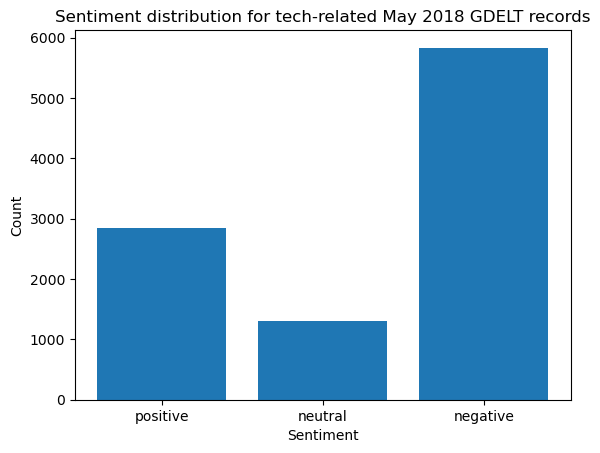

In [29]:
import matplotlib.pyplot as plt

plt.bar(df_sent["sentiment"], df_sent["cnt"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment distribution for tech-related May 2018 GDELT records")
plt.show()


## STREAMING STOP UNCOMMENT
let the stream work for a few minutes
I tested it, and the numbers are slowly going up
just give spark some time

In [30]:
#### run this when you want the streaming query to stop
# query.stop()